# Airbnb: Location, Historical, Price and Amenities Analysis 

In [31]:
# import modules
import os
import csv
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import linregress

# import modules for visualization
import matplotlib.pyplot as plt
import hvplot.pandas
import holoviews as hv
from holoviews import opts
import seaborn as sns

In [32]:
# create an Airbnb dataframe
airbnb_df = pd.read_csv('Resources/air bnb csv with edits.csv')
airbnb_df.head()

,id,name,host_id,host_name,host_since,host_is_superhost,host_identity_verified,instant_bookable,accommodates,amenities,...,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,109,Amazing bright elegant condo park front *UPGRA...,521,Paolo,27-06-2008,f,t,f,6,"[""Elevator"", ""Cable TV"", ""Air conditioning"", ""...",...,2.0,3.0,115,30,730,2,15-05-2016,0.02,1,216
1,2708,Beautiful Furnish Mirrored Mini-Suite w/ Firep...,3008,Chas.,16-09-2008,t,t,t,1,"[""Host greets you"", ""Elevator"", ""Air condition...",...,1.0,1.0,71,30,366,27,6/10/2020,0.35,2,360
2,2732,Zen Life at the Beach,3041,Yoga Priestess,17-09-2008,f,t,f,1,"[""Cooking basics"", ""Host greets you"", ""Smoke a...",...,1.0,1.0,155,1,180,21,27-12-2019,0.18,2,337
3,2864,* Beautiful Master Suite/Jacuzzi Tub/*,3207,Bernadine,25-09-2008,f,t,t,2,"[""Host greets you"", ""Air conditioning"", ""Carbo...",...,1.0,1.0,50,30,730,0,NaN,NaN,1,0
4,5728,Tiny Home in Artistic Oasis near Venice and LAX,9171,Sanni,5/3/2009,t,t,f,2,"[""Lock on bedroom door"", ""Fire extinguisher"", ...",...,1.0,1.0,60,30,1125,310,29-04-2020,2.25,5,337


# Clean Data

In [33]:
# remove unnecessary columns
clean_airbnb_df = airbnb_df.drop(columns=['id', 'name', 'host_id', 'host_identity_verified', 'instant_bookable', 'accommodates',
       'amenities', 'latitude', 'longitude','room_type', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count'])

# change column names for clarity
clean_airbnb_df = clean_airbnb_df.rename(columns={'neighbourhood_group': 'metro'})
clean_airbnb_df = clean_airbnb_df.rename(columns={'neighbourhood':'city'})

# remove host sites where availability is 0/365 days
clean_airbnb_df = clean_airbnb_df[clean_airbnb_df['availability_365'] != 0]

# remove host sites where price is 0
clean_airbnb_df = clean_airbnb_df[clean_airbnb_df['price'] !=0]

# remove host sites where year is null
clean_airbnb_df = clean_airbnb_df.dropna(subset=['host_since'])

# change state names to abbreviations for easy visualization
# create a dictionary mapping state names to abbreviations
state_abbreviations = {
    'California': 'CA',
    'DC':'DC',
    'Florida': 'FL',
    'Hawaii':'HI',
    'Illinois': 'IL',
    'Nevada':'NV',
    'New York ':'NY',
    'Tennessee':'TN',
    'Washington':'WA'
}

# List of state names
state_names = ['California', 'DC', 'Florida', 'Hawaii', 'Illinois', 'Nevada','New York ', 'Tennessee', 'Washington']

# Convert state names to abbreviations
states = [state_abbreviations[state] for state in state_names]

# Apply the mapping to the 'State' column
clean_airbnb_df['State Abbreviation'] = clean_airbnb_df['State'].map(state_abbreviations)

# Modify the 'Metro Area' column to include the state name after the city name
clean_airbnb_df['metro'] = clean_airbnb_df['metro'] + ', ' + clean_airbnb_df['State Abbreviation']

# Drop the 'State' column
clean_airbnb_df =clean_airbnb_df.drop(columns=['State Abbreviation'])

# reformat dates
# Ensure 'host_since' is of string type
clean_airbnb_df['host_since'] = clean_airbnb_df['host_since'].astype(str)

# Now convert to datetime, allowing for multiple formats
# replace '-' with '/' in the 'host_since' column to standardize the format
clean_airbnb_df['host_since'] = clean_airbnb_df['host_since'].str.replace('-', '/')
clean_airbnb_df['host_since'] = pd.to_datetime(clean_airbnb_df['host_since'], dayfirst=True, errors='coerce')
clean_airbnb_df.head()

,host_name,host_since,host_is_superhost,State,metro,city,property_type,price,availability_365
0,Paolo,2008-06-27,f,California,"Los Angeles, CA",Culver City,Entire condominium,115,216
1,Chas.,2008-09-16,t,California,"Los Angeles, CA",Hollywood,Private room in apartment,71,360
2,Yoga Priestess,2008-09-17,f,California,"Los Angeles, CA",Santa Monica,Private room in apartment,155,337
4,Sanni,2009-03-05,t,California,"Los Angeles, CA",Del Rey,Private room in tiny house,60,337
5,Sanni,2009-03-05,t,California,"Los Angeles, CA",Del Rey,Private room in guesthouse,70,332


# Location Analysis
## Add markdowns for key questions, process, analysis and conclusions

# Historical Analysis
## Add markdowns for key questions, process, analysis and conclusions

# Price Analysis

# What are the least and most expensive rental prices and locations?
## Summary Statistics and Outliers
### Due to significant outliers, the median will provide the best average.

In [34]:
# summary statistics for Airbnb prices
clean_airbnb_df["price"].describe()

count    127860.000000
mean        209.162498
std         436.711102
min          10.000000
25%          79.000000
50%         125.000000
75%         209.000000
max       24999.000000
Name: price, dtype: float64

In [35]:
# what is the median price?
median_price = clean_airbnb_df['price'].median()
median_price

125.0

In [36]:
# Create a data frame showing median, min, max for each city
# Group by 'metro' and calculate median, min, and max prices
metro_price_stats_df = pd.DataFrame(clean_airbnb_df.groupby('metro')['price'].agg(['median', 'min', 'max']))

# Reset the index to turn the grouped index into a column
metro_price_stats_df = metro_price_stats_df.reset_index()

# Rename the columns for clarity
metro_price_stats_df.columns = ['Metro Area','Median Price', 'Min Price', 'Max Price']

# Remove white space around metro area names to sort properly
metro_price_stats_df['Metro Area'] = metro_price_stats_df['Metro Area'].str.strip()

# Sort values by metro area
metro_price_stats_df = metro_price_stats_df.sort_values(by='Metro Area', ascending=True)

# Display the resulting DataFrame
metro_price_stats_df

,Metro Area,Median Price,Min Price,Max Price
1,"Bronx, NY",68.0,20,2000
2,"Brooklyn, NY",95.0,10,4000
3,"Broward County, FL",121.0,12,10000
4,"Chicago, IL",99.0,10,10000
5,"Clark County, NV",129.0,13,10000
6,"Hawaii, HI",150.0,15,15000
7,"Honolulu, HI",145.0,10,24600
8,"Kauai, HI",239.0,49,4200
9,"Los Angeles, CA",117.0,10,21053
10,"Manhattan, NY",120.0,19,10000


<Figure size 1000x600 with 0 Axes>

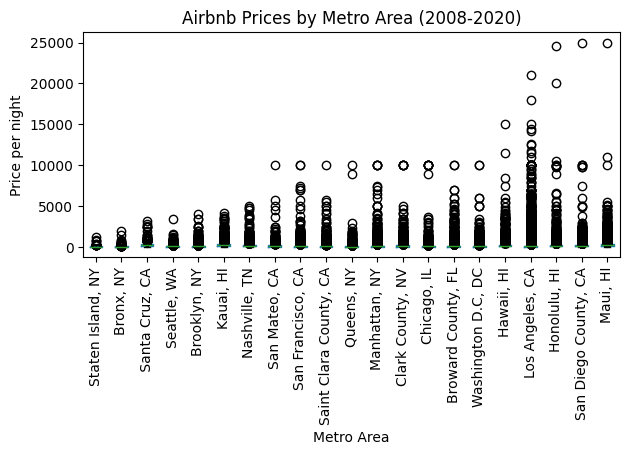

In [37]:
# create a boxplot to show the price range and outliers for each metro area

# Organize plot to display data with max values on the right
# Calculate the max price for each metro area
max_prices = clean_airbnb_df.groupby('metro', observed=False)['price'].max().sort_values()

# Create a new ordered categorical type for the metro areas based on the max prices
clean_airbnb_df['metro'] = pd.Categorical(clean_airbnb_df['metro'], categories=max_prices.index, ordered=True)

plt.figure(figsize=(10, 6))
clean_airbnb_df.boxplot(column='price', by='metro', grid=False)

plt.title('Airbnb Prices by Metro Area (2008-2020)')
plt.suptitle('')  # Suppress the default title to make it cleaner
plt.xlabel('Metro Area')
plt.ylabel('Price per night')
plt.xticks(rotation=90)
plt.tight_layout()

# Save plot as image file
plt.savefig("output_data/Fig3a.png")

plt.show()

<Figure size 1000x600 with 0 Axes>

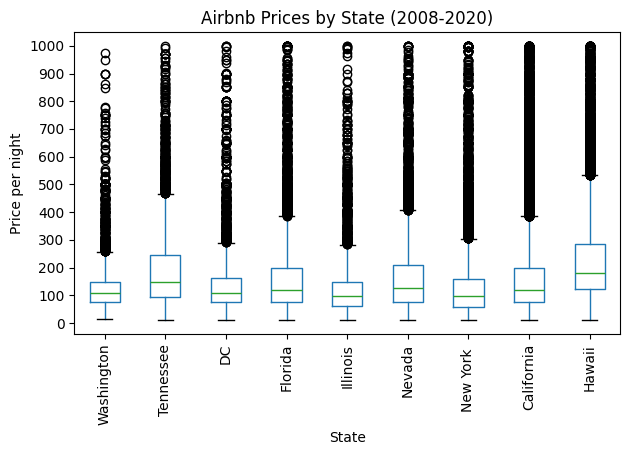

In [38]:
# Create a boxplot that removes extreme outliers
# Prices 1000/night and below BY STATE

# Organize plot to display data with max values on the right
# Calculate the max price for each state 
max_prices = clean_airbnb_df.groupby('State', observed=False)['price'].max().sort_values()

# Create a new ordered categorical type for the metro areas based on the max prices
clean_airbnb_df['State'] = pd.Categorical(clean_airbnb_df['State'], categories=max_prices.index, ordered=True)

# Filter data to remove extreme outliers (prices greater than a certain value)
filtered_df = clean_airbnb_df[clean_airbnb_df.price < 1000]

plt.figure(figsize=(10, 6))
filtered_df.boxplot(column='price', by='State', grid=False)

plt.title('Airbnb Prices by State (2008-2020)')
plt.suptitle('')  # Suppress the default title to make it cleaner

# Set y-axis increments
plt.yticks(range(0, 1100, 100))
#plt.axhline(y=125, color='r', linestyle='--')

plt.xlabel('State')
plt.ylabel('Price per night')
plt.xticks(rotation=90)
plt.tight_layout()

# Save plot as image file
plt.savefig("output_data/Fig3b.png")

plt.show()

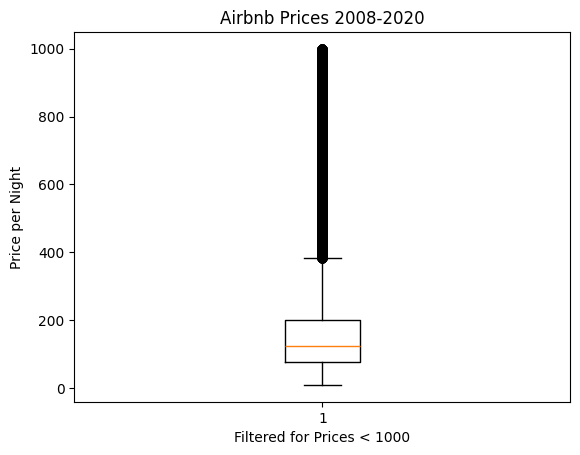

In [39]:
# Filter data to remove extreme outliers (prices greater than a certain value)
filtered_df = clean_airbnb_df[clean_airbnb_df.price < 1000]

# Create a boxplot using Matplotlib
plt.boxplot(filtered_df['price'])
plt.title('Airbnb Prices 2008-2020')
plt.ylabel('Price per Night')
plt.xlabel('Filtered for Prices < 1000')

# Save plot as image file
plt.savefig("output_data/Fig3c.png")

plt.show()

In [40]:
# What kinds of property are associated with the max values for each location?

In [41]:

# find the max price for each metro area
max_price_df = clean_airbnb_df.groupby('metro', observed=False)['price'].max().reset_index()
max_price_df.columns = ['metro', 'max_price']

# filter properties for prices greater than or equal to 15000
filter_max_properties = max_price_df[max_price_df['max_price'] >= 15000]
filter_max_properties

# merge the filter back into the original data frame
max_properties = clean_airbnb_df[clean_airbnb_df['price'].isin(filter_max_properties['max_price'])]

# Sort values by metro area, most expensive to least expensive
max_properties_df = max_properties.sort_values(by='price', ascending=False)

# Drop unncessary columns
max_properties_df = max_properties_df.drop(columns=['State'])

max_properties_df

,host_name,host_since,host_is_superhost,metro,city,property_type,price,availability_365
38104,SeaBreeze,2017-03-22,f,"San Diego County, CA",La Jolla,Entire house,24999,1
85754,Rentals Maui,2015-12-10,f,"Maui, HI",Kihei-Makena,Entire condominium,24999,217
80367,Karin,2018-04-24,f,"Honolulu, HI",North Shore Oahu,Entire villa,24600,365
10520,Marina,2014-11-07,f,"Los Angeles, CA",Bel-Air,Entire villa,21053,363
22310,Viceroy L’Ermitage,2019-09-20,f,"Los Angeles, CA",Beverly Hills,Room in boutique hotel,15000,196
84426,Kauhale,2018-11-23,f,"Hawaii, HI",South Kohala,Entire villa,15000,325


# What are the median and minimum prices for each metro area?

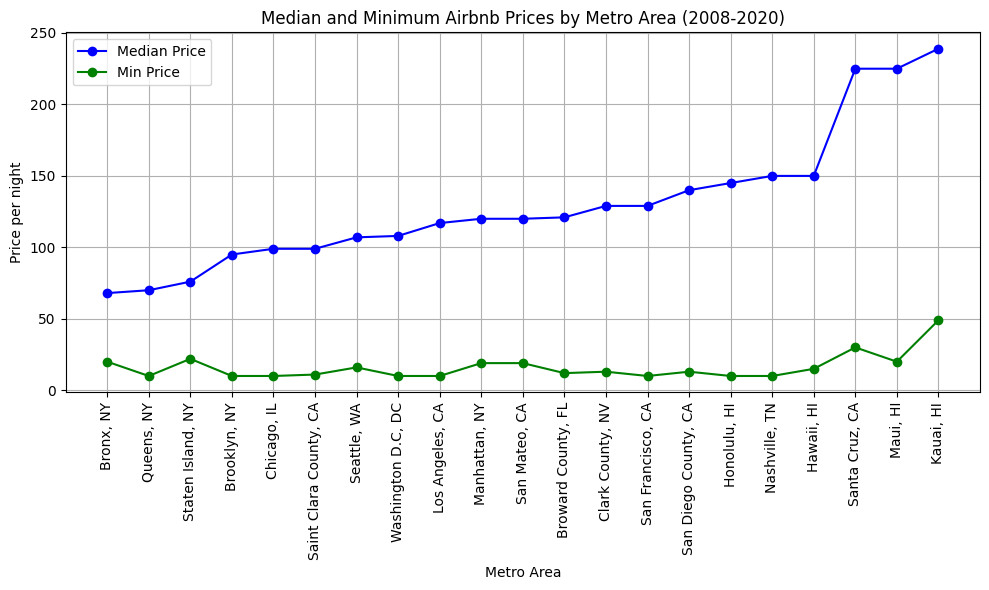

In [42]:
# create line graphs showing median and minimum prices for each metro area

# for clearer visualization, sort stats_df by median values
sorted_df_median = metro_price_stats_df.sort_values(by='Median Price')

# Extract the cities and corresponding prices
cities = sorted_df_median['Metro Area']
median_prices = sorted_df_median['Median Price']
min_prices = sorted_df_median['Min Price']

# Create line plots
plt.figure(figsize=(10, 6))
plt.plot(cities, median_prices, color="blue", label="Median Price", marker='o')
plt.plot(cities, min_prices, color="green", label="Min Price", marker='o')

# Add titles and labels
plt.title("Median and Minimum Airbnb Prices by Metro Area (2008-2020)")
plt.xlabel("Metro Area")
plt.ylabel("Price per night")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.grid()

# Save plot as image file
plt.savefig("output_data/Fig3d.png")

# How did prices change between 2008 and 2020?

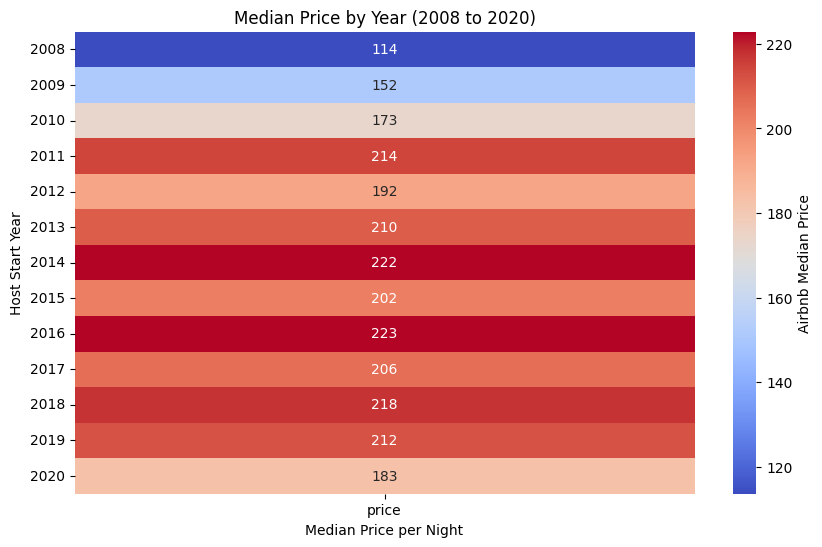

In [43]:
# extract the year from 'host_since' column
clean_airbnb_df['year'] = pd.to_datetime(clean_airbnb_df['host_since']).dt.year

# Convert year to integer
clean_airbnb_df['year'] = clean_airbnb_df['year'].astype(int)

median_price_df = clean_airbnb_df[['year', 'price']]

# Create a pivot table
pivot_table = median_price_df.pivot_table(values='price', index='year', aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(10, 6))  # Adjust size as needed
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt='.0f', cbar_kws={'label': 'Airbnb Median Price'})  # annot=True to display values

# Format heatmap
plt.title('Median Price by Year (2008 to 2020)')
plt.yticks(rotation=360)
plt.xlabel('Median Price per Night')
plt.ylabel('Host Start Year')

# Save plot as image file
plt.savefig("output_data/Fig3e.png")

# Amenities Analysis
## Add markdowns for key questions, process, analysis and conclusions